# Background
- E-commerce fraud detection
- E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, eg. using stolen credit cards, doing money laundray, etc.

- Machine Learning really excels at identifying fraudulent activities. Any website where you put your credict card information has a risk team in charge of avoiding frauds via machine learning.

# Goal

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

# Data
- Company XYZ is an e-commerce site that sells eletronic products
- You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a commom task for data scientists. You only have information about most of the user first transaction on the site and based on that you have to make your classification of fraud or no fraud.
- "Fraud_Data" information about each user first transaction
- "IpAddress_to_Country" mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ip address belongs to the correpsonding country

# Tasks
1. For each user, determine his/her country based on the numeric IP address
2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs. false negatives would impact the model
3. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain to her how the model is making the predictions? Not from a methematical perspective, but from a user perspective. What kind of users are more likely to be classified as at risk? What are their characteristics?
4. Let's say you now have this model which can be used to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of differnet user experiences would you build based on the model output? i.e. based on your prediction, are you going to approve/decline this transaction?


# Summary of findings
- Data is highly imbalanced
- I trained a random forest model, and after parameter tuning, it reached an F1 score 0.687. Since data is high imbalanced, I tried SMOTE technique but it did not improve f1 score. instead, it increases false positives a lot. 
- Characteristics of fraud: half of fraudulent purchase trasactions occur 1 second after account sign up. The more device_id/ip_address that is shared, the higher rate of fraud. 

- Made actionable operation recommendations/proposal for business: in real-time prediction, if a transaction has a predcited probability of fraud lower than 0.3, then we can safely pass. If prob between 0.4-0.7, we need manual investigation. If above 0.8, decline this transaction. 

# 1. Load Data


In [78]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline 
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [3]:
!git clone https://github.com/loganlaioffer/fraudDetection.git

Cloning into 'fraudDetection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [4]:
!cd fraudDetection/
!ls fraudDetection/
# !pip install -U imbalanced-learn
# # !pip install pandas-profiling
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

cv_data.csv   imbalancedFraudDF.csv	test_data.csv	tr_server_data.csv
cv_label.csv  IpAddress_to_Country.csv	test_label.csv


In [5]:
ipURL = 'https://github.com/loganlaioffer/fraudDetection/blob/master/IpAddress_to_Country.csv'
fraudURL = 'https://github.com/loganlaioffer/fraudDetection/blob/master/imbalancedFraudDF.csv'

ipToCountry = pd.read_csv('fraudDetection/IpAddress_to_Country.csv')
fraud_data = pd.read_csv('fraudDetection/imbalancedFraudDF.csv')


In [6]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [7]:
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


 # 2. Map IP Address to Country

 Task 1: Identify country info based on ip_address

In [8]:
ip_address = fraud_data.loc[0,'ip_address']
ip_address

732758368.79972

In [9]:
ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) & (ipToCountry['upper_bound_ip_address'] >= ip_address)]

,lower_bound_ip_address,upper_bound_ip_address,country
4554,729808896.0,734003199,Japan


In [10]:
start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']#number
    #below [] is list of T/F, tmp is a df of shape n * 3, where n is 1 if found a match or 0 if no match
    tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:#found match
        countries.append(tmp['country'].values[0])
    else:#no match
        countries.append('NA')
        
fraud_data['country'] = countries
runtime = time.time() - start 

print("Lookup took", runtime, "seconds.")


Lookup took 231.18155694007874 seconds.


In [11]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


# 3. Data Exploration

In [12]:
#Distribution of the label column
fraud_data['class'].value_counts()


0    136961
1      1415
Name: class, dtype: int64

In [13]:
print(fraud_data['class'].sum()/len(fraud_data['class'])) # 0.1 percent

0.010225761692779094


In [14]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [16]:
# ! pip install pandas-profiling

# import pandas_profiling

# #Inline summary report without saving report as object
# pandas_profiling.ProfileReport(fraud_data)

#simpler version without installing pandas_profiling
fraud_data.describe().transpose()

# will give warnings on missing, correlation, constant value(0 variance), etc, see http://nbviewer.jupyter.org/github/JosPolfliet/pandas-profiling/blob/master/examples/meteorites.ipynb


,count,mean,std,min,25%,50%,75%,max
user_id,138376.0,2.001490e+05,1.152268e+05,2.000000,1.008948e+05,2.000005e+05,2.997452e+05,4.000000e+05
purchase_value,138376.0,3.693899e+01,1.832109e+01,9.000000,2.200000e+01,3.500000e+01,4.900000e+01,1.540000e+02
age,138376.0,3.312587e+01,8.623645e+00,18.000000,2.700000e+01,3.300000e+01,3.900000e+01,7.600000e+01
ip_address,138376.0,2.154381e+09,1.250563e+09,52093.496895,1.085079e+09,2.156471e+09,3.249150e+09,4.294850e+09
class,138376.0,1.022576e-02,1.006045e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


### 3.1 Missing values & Outlier

In [17]:
# count of NaN in each column
fraud_data.isna().sum()
#fraud_data.isnull().sum(axis = 0)


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

Text(0, 0.5, 'Amount')

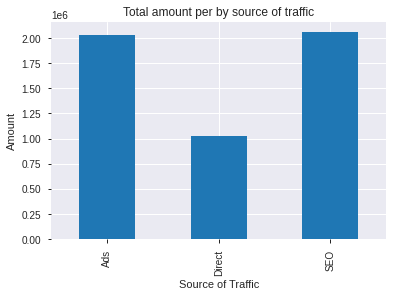

In [23]:
# eda
var = fraud_data.groupby('source').purchase_value.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per by source of traffic")
ax1.set_xlabel('Source of Traffic')
ax1.set_ylabel('Amount')

In [45]:
print(fraud_data.source.value_counts())

SEO       55766
Ads       54913
Direct    27697
Name: source, dtype: int64


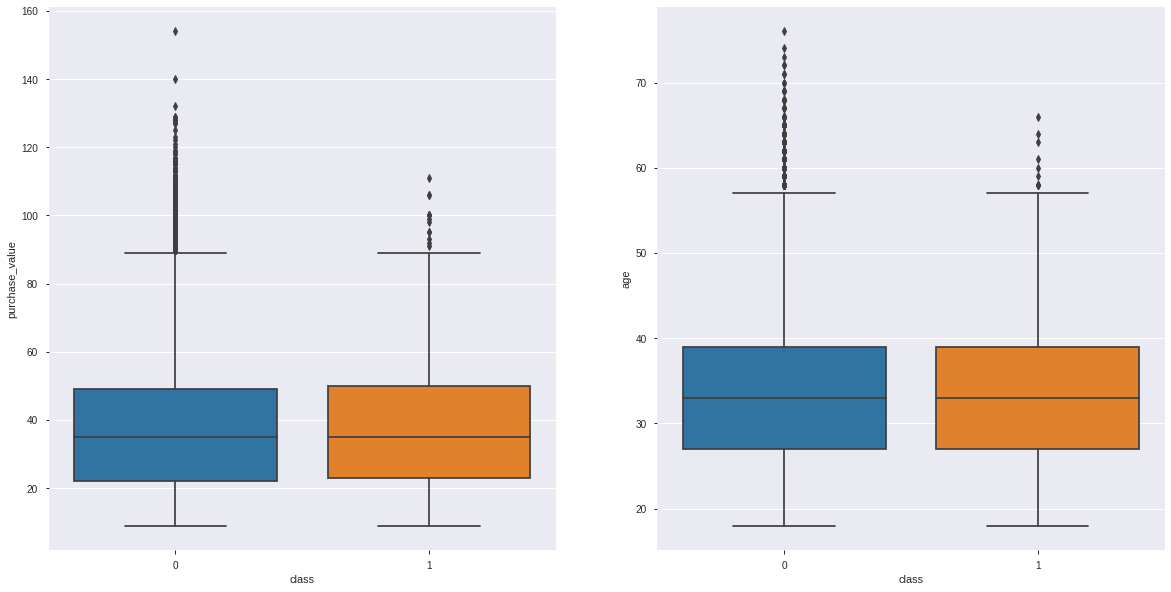

In [25]:
# boxplot for numerical feature: purchase_value, age
_,axss = plt.subplots(1,2, figsize=[20,10])
sns.boxplot(x='class', y ='purchase_value', data=fraud_data, ax=axss[0])
sns.boxplot(x='class', y ='age', data=fraud_data, ax=axss[1])


purchase value and age do not have big difference between fraud/nonfraud activities

### 3.2 Feature Engineering

In [26]:
# check if column user_id is unique(no dup) for time related aggregates
print(fraud_data.user_id.nunique())
print(len(fraud_data.index))


138376
138376


All of the user_id has only the first 1 transaction, no way to do time based aggregates, e.g. amount or counts in past 1 day for this user

In [27]:
print(fraud_data.signup_time.min())
print(fraud_data.signup_time.max())

2015-01-01 00:00:42
2015-08-18 04:40:29


In [28]:
print(fraud_data.purchase_time.min())
print(fraud_data.purchase_time.max())

2015-01-01 00:00:47
2015-12-16 02:56:05


In [29]:
#time related features
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(
        fraud_data['signup_time'])).dt.total_seconds()

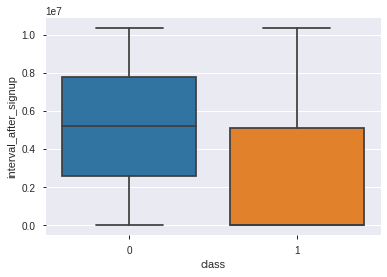

In [30]:
sns.boxplot(x='class', y ='interval_after_signup', data=fraud_data)


In [31]:
fraud_data.groupby('class')['interval_after_signup'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,136961.0,5.191179e+06,2.988589e+06,137.0,2588829.0,5194911.0,7781319.0,10367972.0
1,1415.0,2.570226e+06,3.398386e+06,1.0,1.0,1.0,5121468.5,10354001.0


Important finding: fraud activities seems to occur right after account sign up. The median of fraudulent transactions is 1 second after account sign up.

In [32]:
fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear


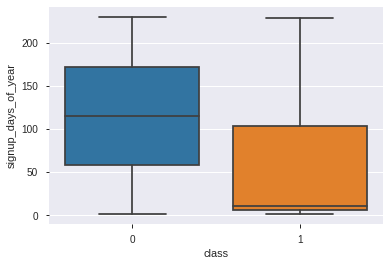

In [33]:
sns.boxplot(x='class', y ='signup_days_of_year', data=fraud_data)


In [34]:
fraud_data.groupby('class')['signup_days_of_year'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,136961.0,115.008367,66.093892,1.0,58.0,115.0,172.0,230.0
1,1415.0,56.732155,69.598381,1.0,6.0,11.0,104.0,229.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


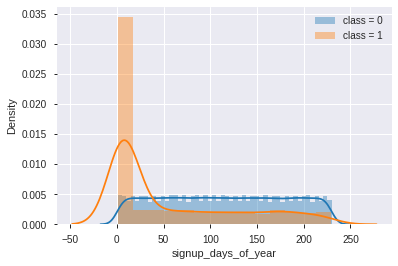

In [35]:
# density plot by class
sns.distplot(fraud_data[fraud_data['class'] == 0]['signup_days_of_year'], hist = True, kde = True, label='class = 0')
sns.distplot(fraud_data[fraud_data['class'] == 1]['signup_days_of_year'], hist = True, kde = True, label='class = 1')
plt.legend()
plt.show()


Finding: Fraudulent activities seem to concentate on the beginning of year.

In [36]:
#bed time operation
fraud_data['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['signup_time']).hour


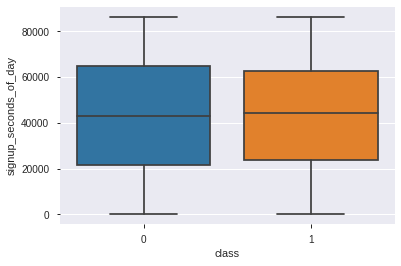

In [37]:
sns.boxplot(x='class', y ='signup_seconds_of_day', data=fraud_data)


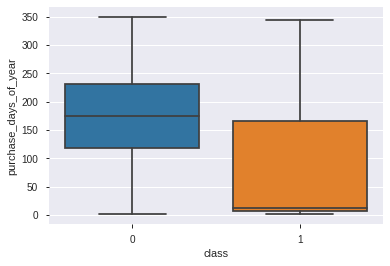

In [38]:
# purchase related time features
fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear
sns.boxplot(x='class', y ='purchase_days_of_year', data=fraud_data)


Similar to sign up day of year, fraudulent activities seem to concentate on the beginning of year.

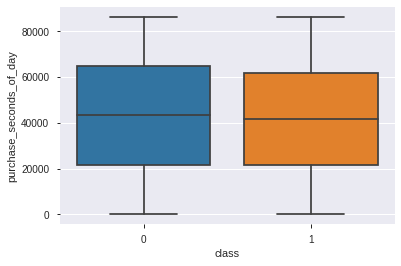

In [40]:
# bed time operation
fraud_data['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['purchase_time']).hour

sns.boxplot(x='class', y ='purchase_seconds_of_day', data=fraud_data)

Fraudent activities does not occur at hypothesized bed time. (early A.M. or late P.M) 

In [42]:
# drop some columns
fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis=1)

In [43]:
fraud_data.head()
#note there are NAs in country

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,76405,124,50090
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,25792,252,67253
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,141,21783,190,29114


# 4. Train/Test split

In [66]:
y = fraud_data['class']
X = fraud_data.drop(['class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


# 5. Feature Preprocessing (Categorical Feature Encoding)

Convert categorical features with high cadinality to numericals

In [67]:
X_train['country'].value_counts(ascending=True)
#drawback: collision in the same bucket(no differentiation for these countries)

Gambia                                1
Madagascar                            1
Cape Verde                            1
British Indian Ocean Territory        1
Virgin Islands (U.S.)                 1
                                  ...  
United Kingdom                     3242
Japan                              5378
China                              8797
NA                                16267
United States                     42547
Name: country, Length: 176, dtype: int64

In [68]:
# one hote encoding for source and browser
X_train = pd.get_dummies(X_train, columns=['source', 'browser']) 

# convert sex to 0 and 1
X_train['sex'] = (X_train.sex == 'M').astype(int)


In [69]:
# frequency encoding for high cardinality categoricial features

# the more a device is shared, the more suspicious
X_train_device_id_mapping = X_train.device_id.value_counts(dropna=False)
X_train['n_dev_shared'] = X_train.device_id.map(X_train_device_id_mapping)# number of times device_id occurred in train data

# the more a ip is shared, the more suspicious
X_train_ip_address_mapping = X_train.ip_address.value_counts(dropna=False)
X_train['n_ip_shared'] = X_train.ip_address.map(X_train_ip_address_mapping)

# the less visit from a country, the more suspicious
X_train_country_mapping = X_train.country.value_counts(dropna=False)
X_train['n_country_shared'] = X_train.country.map(X_train_country_mapping)#lots of NAs in country column, #without dropna=False will produce nan in this col

X_train = X_train.drop(['device_id','ip_address','country'], axis=1)



In [70]:
##########################
X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)

# the more a device is shared, the more suspicious
X_test['n_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_test['n_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_test['n_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna=False))

X_test = X_test.drop(['device_id','ip_address','country'], axis=1)

# if the levels/values of the column in train and test data are pretty much the same(lots of overlap), e.g. country, 
# then we should apply the above 3 X_train_mappings (generated from X_train) on X_test(like below), 
# rather than using the new mapping generated from X_test

# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/target-encoding.html
# the more a device is shared, the more suspicious
# X_test['n_dev_shared'] = X_test.device_id.map(X_train_device_id_mapping) # if apply train mapping, most of the levels in test does not occur in train, so most are null after converting

# the more a ip is shared, the more suspicious
# X_test['n_ip_shared'] = X_test.ip_address.map(X_train_ip_address_mapping)

# the less visit from a country, the more suspicious
# X_test['n_country_shared'] = X_test.country.map(X_train_country_mapping)

#but here device_id, ip_address has few overlap between train and test, if we apply the above 
# 3 X_train_mappings (generated from X_train) on X_test, then most of the X_test will be NaN

#target encoding


### Normalization

needs to be brought to the same scale for models like LR with regularization(that are not tree based)

normalize (min-max) to [0,1], standardize(StandardScaler) to normal, mu=0,var = 1 can < 0, so I do normalize here



In [57]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
8660,10,1,33,598553.0,19,14353,26,8106,0,0,1,1,0,0,0,0,1,1,8797
31055,86,0,33,4656631.0,35,24402,89,15433,1,0,0,0,0,0,1,0,1,1,3029
1788,35,1,37,3509728.0,77,43391,118,10719,1,0,0,0,0,1,0,0,1,1,11
128970,34,0,29,1102702.0,185,53345,198,32847,1,0,0,0,0,1,0,0,1,1,2134
3928,17,1,38,2241832.0,142,73917,168,69349,0,0,1,0,0,1,0,0,1,1,3029


In [71]:
#Compute the train minimum and maximum to be used for later scaling:
unscaled_features = ['purchase_value', 'age', 'interval_after_signup',
       'signup_days_of_year', 'signup_seconds_of_day', 'purchase_days_of_year',
       'purchase_seconds_of_day', 'n_dev_shared', 'n_ip_shared', 'n_country_shared']
scaler = preprocessing.MinMaxScaler().fit(X_train[unscaled_features]) 
#print(scaler.data_max_)

#transform the training data and use them for the model training
X_train[unscaled_features] = scaler.transform(X_train[unscaled_features])

#before the prediction of the test data, apply the same scaler obtained from above on X_test, not fitting a brandnew scaler on test
X_test[unscaled_features] = scaler.transform(X_test[unscaled_features])



In [72]:
X_train.n_dev_shared.value_counts(dropna=False)

0.0    105310
0.2      4878
0.4       360
0.6       116
0.8        30
1.0         6
Name: n_dev_shared, dtype: int64

In [73]:
X_test.n_dev_shared.value_counts(dropna=False)

0.0    27292
0.2      366
0.4       18
Name: n_dev_shared, dtype: int64

# 5. Model Training

Simple LogisticRegression model

In [74]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# predict on test
y_pred=logreg.predict(X_test)

In [76]:
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0
print(classification_report(y_test,y_pred))


        pred_0  pred_1
true_0   27393       0
true_1     271      12
recall = 0.04240282685512368
precision = 1.0


Simple RF model

In [79]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train, y_train)

# predict class labels 0/1 for the test set
predicted = classifier_RF.predict(X_test)

# generate class probabilities
probs = classifier_RF.predict_proba(X_test)

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0
print(classification_report(y_test,predicted))

accuracy_score is: : 0.9951221274750687
roc_auc_score is: : 0.7550976694543846
f1_score is: : 0.6867749419953596
confusion_matrix is: 
        pred_0  pred_1
true_0   27393       0
true_1     135     148
recall = 0.5229681978798587
precision = 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27393
           1       1.00      0.52      0.69       283

    accuracy                           1.00     27676
   macro avg       1.00      0.76      0.84     27676
weighted avg       1.00      1.00      0.99     27676



SMOTE sampling

In [80]:
#Wrong way to sampling: smote before split train/test, then test data does not reflect true distribution in reality, 
#and “blend” information from the test set into the training of the model. overfit! think about the case of simple 
#oversampling (where I just duplicate observations). If I upsample a dataset before splitting it into a train and 
#validation set, I could end up with the same observation in both datasets

#https://imbalanced-learn.org/en/stable/install.html

# Install
# imbalanced-learn is currently available on the PyPi’s reporitories and you can install it via pip:

# pip install -U imbalanced-learn

#oversampling on only the training data, the right way! 
#sampling_strategy = number of samples in the majority class over the number of samples in the minority class after resampling

smote = SMOTE(random_state=12)
x_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[     0 109568]
 [     1 109568]]


In [81]:
#RF on smoted training data
classifier_RF_sm = RandomForestClassifier(random_state=0)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm = classifier_RF_sm.predict(X_test)

# generate class probabilities
probs_sm = classifier_RF_sm.predict_proba(X_test)

# generate evaluation metrics
print("%s: %r" % ("accuracy_score_sm is: ", accuracy_score(y_test, predicted_sm)))
print("%s: %r" % ("roc_auc_score_sm is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print("%s: %r" % ("f1_score_sm is: ", f1_score(y_test, predicted_sm )))#string to int

print ("confusion_matrix_sm is: ")
cm_sm = confusion_matrix(y_test, predicted_sm)
cmDF = pd.DataFrame(cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall or sens_sm =',float(cm_sm[1,1])/(cm_sm[1,0]+cm_sm[1,1]))
print('precision_sm =', float(cm_sm[1,1])/(cm_sm[1,1] + cm_sm[0,1]))

#different AUC??

accuracy_score_sm is: : 0.8486775545599075
roc_auc_score_sm is: : 0.767858338367376
f1_score_sm is: : 0.07467962881131242
confusion_matrix_sm is: 
        pred_0  pred_1
true_0   23319    4074
true_1     114     169
recall or sens_sm = 0.5971731448763251
precision_sm = 0.03983030874381334


SMOTE resampling has increased false positives a lot.

# Parameter tuning by GridSearchCV

Eval metrics for GridSearchCV over all fits upon combination of parameters and cv

In [86]:
# Eval metrics to be calculated for each combination of parameters and cv, they are all calculated(by scoring), but not necessarily used to pick the optimal(by refit)
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
    
}

In [87]:
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search



Optimizing on f1_score on LR

In [88]:
# C: inverse of regularization strength, smaller values specify stronger regularization
LRGrid = {"C" : np.logspace(-2,2,5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
logRegModel = LogisticRegression(random_state=0)

grid_search_LR_f1 = grid_search_wrapper(logRegModel, LRGrid, refit_score='f1_score')

Best params for f1_score
{'C': 1.0, 'penalty': 'l2'}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27393       0
true_1     271      12
	roc_auc_score is: : 0.7894267434911216
	f1_score is: : 0.08135593220338982
recall =  0.04240282685512368
precision =  1.0


Optimizing on f1_score on RF

In [89]:
parameters = {        
'max_depth': [None, 5, 15],
'n_estimators' :  [10,150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

clf = RandomForestClassifier(random_state=0)

In [90]:
grid_search_rf_f1 = grid_search_wrapper(clf, parameters, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': 5, 'n_estimators': 10}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27393       0
true_1     135     148
	roc_auc_score is: : 0.7929720509701802
	f1_score is: : 0.6867749419953596
recall =  0.5229681978798587
precision =  1.0


In [91]:
best_rf_model_f1 = grid_search_rf_f1.best_estimator_
best_rf_model_f1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 0.2}, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [92]:
results_f1 = pd.DataFrame(grid_search_rf_f1.cv_results_)
results_sortf1 = results_f1.sort_values(by='mean_test_f1_score', ascending=False)
results_sortf1[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()



,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
2,1.000,0.522,0.686,1.0,0.522,0.686,5,"{0: 1, 1: 0.2}",10
9,0.998,0.522,0.686,1.0,0.522,0.686,5,"{0: 1, 1: 1}",150
3,0.998,0.522,0.686,1.0,0.522,0.686,5,"{0: 1, 1: 0.2}",150
7,0.998,0.522,0.686,1.0,0.999,1.000,None,"{0: 1, 1: 1}",150
13,0.998,0.522,0.686,1.0,0.999,1.000,None,"{0: 1, 1: 100}",150


In [93]:
#Var Importance
pd.DataFrame(best_rf_model_f1.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)




,importance
interval_after_signup,0.618852
n_dev_shared,0.173638
purchase_days_of_year,0.144865
n_ip_shared,0.040686
signup_days_of_year,0.006269
age,0.002822
purchase_seconds_of_day,0.002567
signup_seconds_of_day,0.002555
browser_FireFox,0.002187
source_Direct,0.001902


Optimizing recall_score on RF

In [94]:
grid_search_rf_recall = grid_search_wrapper(clf, parameters, refit_score='recall_score')

Best params for recall_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': 5, 'n_estimators': 10}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27098     295
true_1     124     159
	roc_auc_score is: : 0.7865129326196796
	f1_score is: : 0.43147896879240166
recall =  0.5618374558303887
precision =  0.3502202643171806


In [95]:
best_RF_model_recall = grid_search_rf_recall.best_estimator_
best_RF_model_recall

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 100}, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [96]:
# predict class labels for the test set
predictedBest_recall = best_RF_model_recall.predict(X_test)

# generate class probabilities
probsBest_recall = best_RF_model_recall.predict_proba(X_test)

results_recall = pd.DataFrame(grid_search_rf_recall.cv_results_)# recall score is different from above, as above is metric on test data, this is performance on cv data
results_sortrecall = results_recall.sort_values(by='mean_test_recall_score', ascending=False)
results_sortrecall[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()
#recall is worse than default rf?? no this is on test, but train recall is better

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
14,0.154,0.617,0.246,0.159,0.640,0.254,5,"{0: 1, 1: 100}",10
15,0.163,0.614,0.256,0.171,0.645,0.269,5,"{0: 1, 1: 100}",150
0,0.995,0.522,0.685,0.999,0.876,0.934,None,"{0: 1, 1: 0.2}",10
8,0.995,0.522,0.685,0.997,0.521,0.684,5,"{0: 1, 1: 1}",10
13,0.998,0.522,0.686,1.000,0.999,1.000,None,"{0: 1, 1: 100}",150


# Project tasks

In [97]:
#for task 3, based on the above var importance
trainDF = pd.concat([X_train, y_train], axis=1)
pd.crosstab(trainDF["n_dev_shared"],trainDF["class"])
#the larger n_dev_shared, the higher rate of fraud

class,0,1
n_dev_shared,,
0.0,104853,457
0.2,4509,369
0.4,171,189
0.6,29,87
0.8,6,24
1.0,0,6


In [98]:
fraud_data.groupby("class")[['interval_after_signup']].mean()#action velocity(consecutive operations/actions of user)
#interval_after_signup on frauds are significantly lower compared to legits

,interval_after_signup
class,
0,5.191179e+06
1,2.570226e+06


In [99]:
fraud_data.groupby("class")[['interval_after_signup']].median()#1
#more than half of fraud happened 1s after signed up

,interval_after_signup
class,
0,5194911.0
1,1.0


In [100]:
fraud_data[fraud_data['class'] == 1].head(100)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
136961,24,VLHGCDPFCICDA,SEO,Chrome,F,33,3.432126e+09,1,United States,3327952.0,218,80113,257,38465
136962,14,YLUQSRNYYIPXU,Ads,Chrome,M,40,3.905319e+09,1,NA,1.0,12,4207,12,4208
136963,63,ABUBCQDATQMQH,Ads,FireFox,F,46,5.505670e+08,1,United States,7640070.0,49,40723,137,77593
136964,34,QHEODGCAVJKIQ,SEO,Chrome,M,37,9.408096e+08,1,United States,1.0,12,77710,12,77711
136965,76,DAKVYHKIEYRBH,SEO,Chrome,F,48,6.361041e+08,1,Hungary,1.0,10,48421,10,48422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137056,21,AIGPGDVRDKOKT,SEO,FireFox,F,45,3.058136e+09,1,India,1.0,2,69762,2,69763
137057,52,PQGKGQACIARBV,Ads,Chrome,F,36,7.203338e+08,1,China,1.0,9,77018,9,77019
137058,54,XHZBVWFWHSGTQ,SEO,FireFox,M,50,2.249217e+09,1,United States,1.0,1,32483,1,32484
137059,10,WETYPHOQVLWMK,Ads,FireFox,M,36,2.293333e+09,1,United States,1.0,7,63914,7,63915


In [101]:
#for task 4, how to use the prediction:
t = (10 * probsBest_recall[:, 1]).astype(int)
unique, counts = np.unique(t, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1   324]
 [    2 21736]
 [    3  5090]
 [    4    72]
 [    5   101]
 [    6   168]
 [    7    44]
 [    8    25]
 [    9   114]
 [   10     2]]


### recommended:
### green: 1 - 3 pass
### grey: 4-7 need manual investigation
### red: 8,9 decline

In [ ]:
# try XGBOOST and compare the performance of RF